In [1]:
!jt -t grade3 -tf merriserif -tfs 16 -nf ptsans -nfs 9
# !jt -r

# A visual guide to ScanDy


In [2]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import ipywidgets as ipyw

# from source.models.pxlDDM import PxlDDModel
# from source.models.objDDM import ObjDDModel
from scandy.utils.dataclass import Dataset
# import source.utils.functions as uf
# import source.utils.visualizations as uv

from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution

/home/nico/project_code/ScanDy


## Load the *VidCom* dataset

In [2]:
datadict = {
    "PATH": "/scratch/nroth/VidCom/VidCom/", # HPC
    'FPS' : 30,
    'PX_TO_DVA' : 0.06,
    'FRAMES_ALL_VIDS' : 300,
    'gt_foveation_df' : '2021-12-04_VidCom_GT_fov_df',
    'gt_fovframes_nss_df' : 'gt_fovframes_nss_df.csv',
    'trainset' : ['field03'], #sorted(['dance02', 'park01', 'park06', 'road04', 'road05', 'room01', 'room02', 'walkway03', 'dance01', 'field03', 'foutain02', 'garden04', 'garden06', 'garden07', 'garden09', 'park09', 'road02', 'robarm01', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02']),
    'testset' : [],
}
VidCom = Dataset(datadict)

### Access (precomputed) data for one frame

* Object masks
    * Segmentation: https://github.com/facebookresearch/detectron2
    * Tracking: https://github.com/nwojke/deep_sort

* Low-level features: https://github.com/csmslab/dynamic-proto-object-saliency
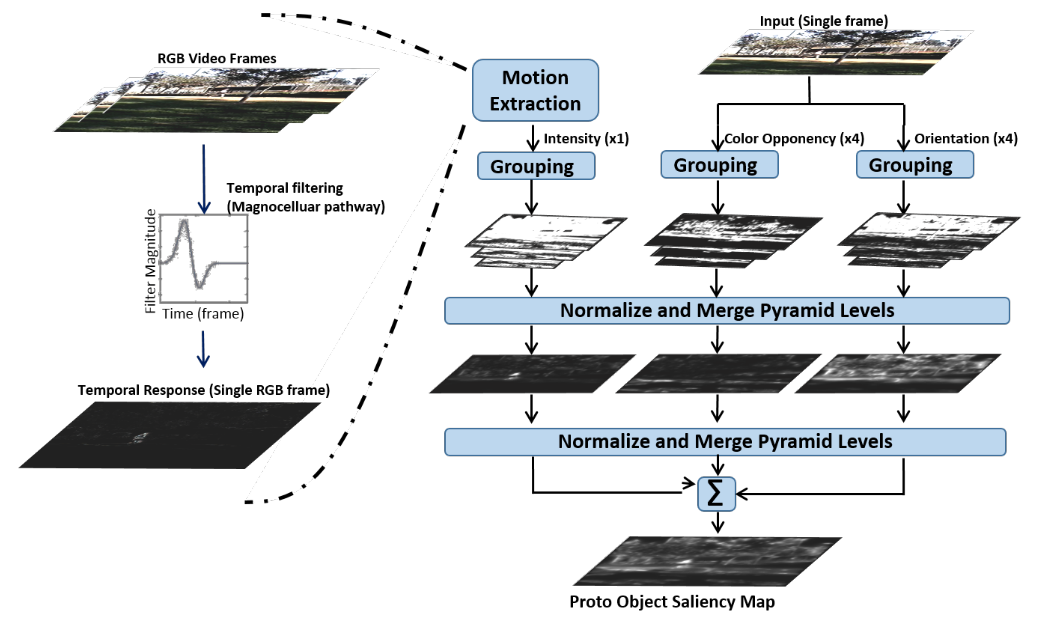

* High-level features: https://github.com/MichiganCOG/TASED-Net
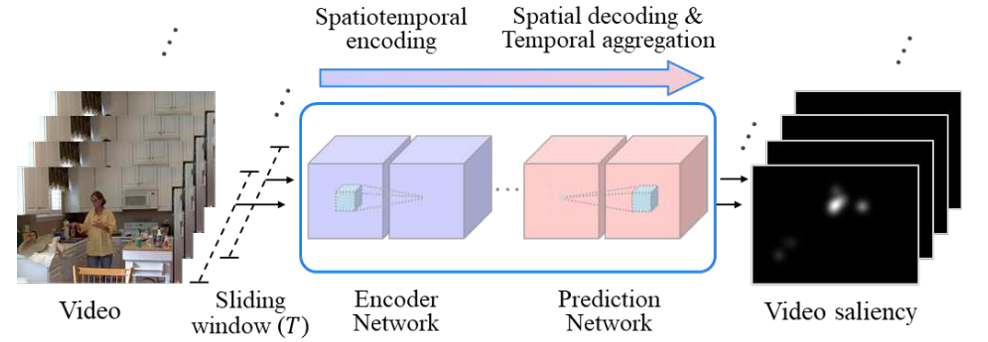

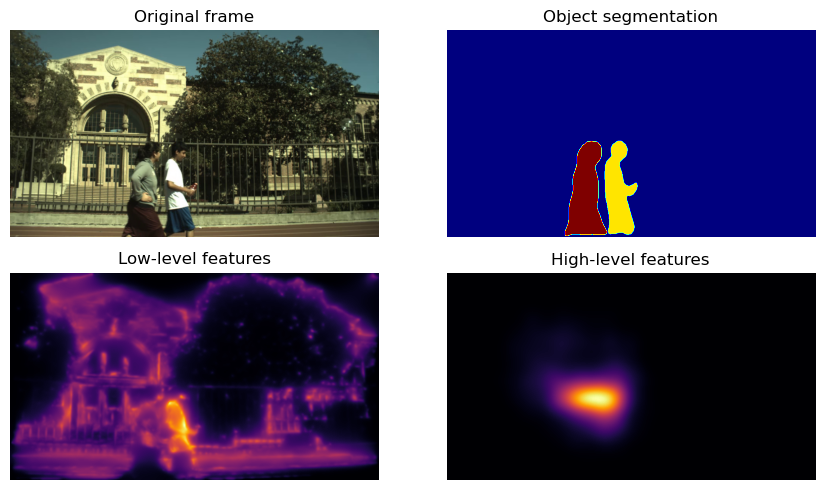

In [3]:
video = 'field03'
frame = 230

vidframe = VidCom.get_videoframes(video)[frame]
objects = VidCom.get_objectmasks(video)[frame]
low_level_features = VidCom.get_featuremaps(video, 'molin', centerbias=None)[frame]
#low_level_features_with_cb = VidCom.get_featuremaps(video, 'molin', centerbias='anisotropic_default')[frame]
high_level_features = VidCom.get_featuremaps(video, 'TASEDnet', centerbias=None)[frame]

fig, axs = plt.subplots(2,2, figsize=(9,5), dpi=100)
axs[0,0].imshow(vidframe); axs[0,0].set(title='Original frame')
axs[0,1].imshow(objects, cmap='jet'); axs[0,1].set(title='Object segmentation')
axs[1,0].imshow(low_level_features, cmap='inferno'); axs[1,0].set(title='Low-level features')
axs[1,1].imshow(high_level_features, cmap='inferno'); axs[1,1].set(title='High-level features')
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout(); plt.show()

In [4]:
low_level_features.max()

0.41850389568556245

(-0.5, 959.5, 539.5, -0.5)

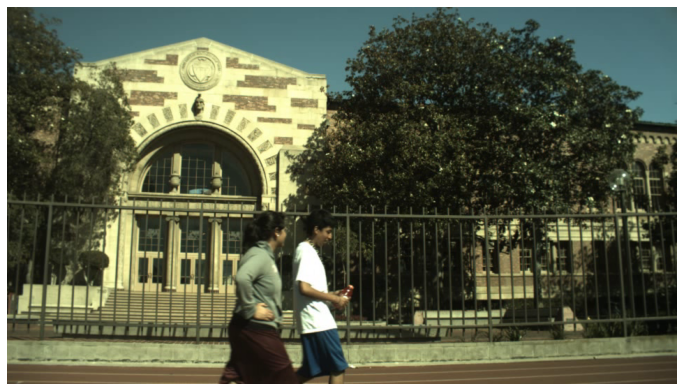

In [5]:
vidframe = VidCom.get_videoframes(video)[frame+1]
objects = VidCom.get_objectmasks(video)[frame]
plt.figure(figsize=(12,8))
plt.imshow(vidframe)
#plt.imshow(objects, alpha=0.5)
plt.axis('off')

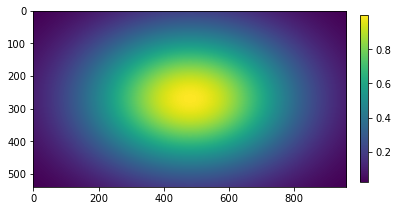

In [6]:
def anisotropic_centerbias(xmax, ymax, sigx2=0.22, v=0.45, mean_to_1=False):
    '''
    Function returns a 2D anisotropic Gaussian center bias across the whole frame. 
    Inspired by Clark & Tatler 2014 / also used in Nuthmann2017 
    Image dimensions are normalized to [-1,1] in x and [-a,a] in y, with aspect ratio a.
    sigx2 is the variance of the Gaussian in x direction, default: 0.22 (Clark&Tatler2014)
    Influence may be smaller (sigx2 bigger) in dynamic scenes (Cristino&Baddeley2009; tHart2009) 
    v is a meassure for the anisotropy, default: 0.45 (Clark&Tatler2014 for a=4:3)
    mean_to_1: might make sense to not reduce the overall saliency in each frame.
    '''
    X, Y = np.meshgrid(np.linspace(-1,1, xmax), np.linspace(-ymax/xmax, ymax/xmax, ymax))
    G = np.exp(- (X**2 / (2*sigx2) + Y**2 / (2*sigx2*v)))
    if mean_to_1:
        G = G / np.mean(G)
    return G 

cb = uf.anisotropic_centerbias(VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y)
im = plt.imshow(cb); plt.colorbar(im,fraction=0.025, pad=0.04); plt.show()

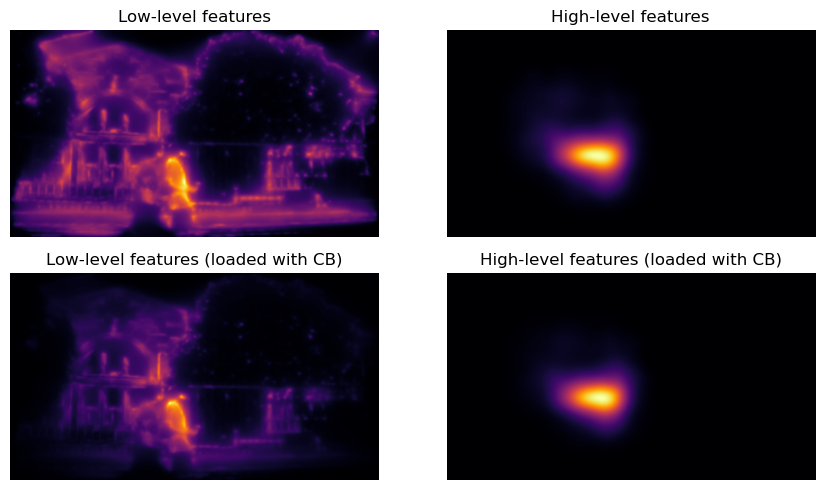

In [7]:
fig, axs = plt.subplots(2,2, figsize=(9,5), dpi=100)
plt.set_cmap('inferno')
axs[0,0].imshow(low_level_features); axs[0,0].set(title='Low-level features')
axs[0,1].imshow(high_level_features); axs[0,1].set(title='High-level features')

low_level_features_with_cb = VidCom.get_featuremaps(video, 'molin', centerbias='anisotropic_default')[frame]
high_level_features_with_cb = VidCom.get_featuremaps(video, 'TASEDnet', centerbias='anisotropic_default')[frame]

axs[1,0].imshow(low_level_features_with_cb); axs[1,0].set(title='Low-level features (loaded with CB)')
axs[1,1].imshow(high_level_features_with_cb); axs[1,1].set(title='High-level features (loaded with CB)')
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout(); plt.show()

(-0.5, 959.5, 539.5, -0.5)

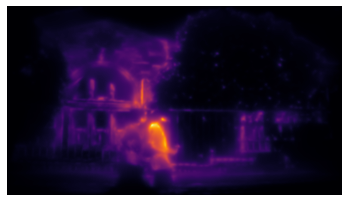

In [8]:
plt.imshow(low_level_features_with_cb)#, vmin=0, vmax=1)
plt.axis('off')

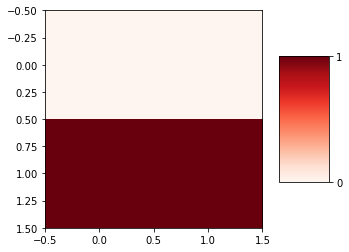

In [9]:
plt.imshow(np.array([[0,0],[1,1]]), cmap='Reds')
plt.colorbar(aspect=2.5, ticks=[0,1])

--  --
$$ presentation$$ 
-- -- 

## Visual sensitivity

In [10]:
def sensitivity(OBA, att_dva, gazeloc_x):
    gaze_loc = [400, int(gazeloc_x)] # yval, xval (python / numpy is very confusing here...)
    # simple Gaussian (variable size)
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       att_dva * VidCom.DVA_TO_PX)
    if OBA:  # object-based attention
        obj_id = objects[gaze_loc[0], gaze_loc[1]]
        if obj_id > 0:
            S[objects==obj_id] = 1.
    plt.figure(figsize=(12,6))
    im = plt.imshow(S, cmap='bone', vmax=1, vmin=0)
    # plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('off')
    plt.scatter(gaze_loc[1], gaze_loc[0], marker='x', s=1000, c='green', lw=5)
    plt.show()

ipyw.interactive(sensitivity, 
                 OBA=[False, True],
                 gazeloc_x=ipyw.FloatSlider(value=350., min=200, max=500, step=50),
                 att_dva=ipyw.FloatSlider(value=10., min=1, max=20, step=1))
   

interactive(children=(Dropdown(description='OBA', options=(False, True), value=False), FloatSlider(value=10.0,…

--  --
$$ presentation$$ 
-- -- 

## Scanpath history

Take an example from the ground truth scanpaths by filtering for one subject watching the example video...

Data format: just foveation events (no noise / saccades)

In [11]:
frame = 230
# use the data from one human subject for the example video
sp_history = VidCom.gt_foveation_df[(VidCom.gt_foveation_df.video==video) & (VidCom.gt_foveation_df.subject=='SN')]
# only up to our example frame
sp_history = sp_history[sp_history.frame_start<=frame]
sp_history

,duration_ms,x_start,x_end,y_start,y_end,frame_start,frame_end,subject,video,object,sac_amp_dva,sac_angle_h,sac_angle_p,fov_category,ret_times,nfov
373,270.833,480,484,270,276,0,8,SN,field03,Ground,NaN,NaN,NaN,B,NaN,0
374,83.333,333,332,337,335,11,13,SN,field03,Ground,9.692925,155.497341,NaN,B,NaN,1
375,616.666,259,222,397,396,15,34,SN,field03,Object 1,5.716083,140.964487,-14.532853,D,NaN,2
376,2029.166,208,121,389,399,41,101,SN,field03,Object 1,3.097418,-171.085073,47.950440,I,NaN,3
377,183.334,303,307,298,297,114,120,SN,field03,Ground,7.893136,-43.768023,127.317050,B,NaN,4
378,45.834,301,302,216,217,137,139,SN,field03,Ground,4.921463,-91.397181,-47.629158,B,NaN,5
379,129.167,277,267,172,167,147,151,SN,field03,Ground,3.007191,-118.610460,-27.213279,B,NaN,6
380,216.667,142,177,340,339,190,197,SN,field03,Object 2,12.931218,128.784364,-112.605176,D,NaN,7
381,412.500,145,244,344,336,198,210,SN,field03,Object 3,0.300000,53.130102,-75.654262,D,NaN,8
382,479.167,302,416,326,319,212,226,SN,field03,Object 2,9.481709,-6.540386,-59.670488,R,500.000000,9


### Location-based IOR
*ScanDy* side note: In practice, this is updated, not calculated anew for each frame.

$    I(x,y,t) = \min\left(1, \sum_{h=1}^{N_F} \max\left(0, \left( 1 - r \cdot (t-t_h)\right)  G_I(x,y)^{(h)}\right)\right),
$

In [12]:
gaze_loc = [400, 350]
assert frame == 230, f"Frame was changed to {frame} in previous cell, should be 230!"

def inhibition(ior_dva, ior_decay, show_prev_target):
    r = 1/ior_decay
    IOR_maps = []
    for s, sac_time in enumerate(sp_history.frame_start[:-1]):
        # discount inhibition with time (see next cell...)
        weight = 1-r*(frame - sac_time)
        if weight >0:
            # draw a Gaussian around every past target location that is "not yet forgotten"
            ior_map = weight * uf.gaussian_2d(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s],
                                              VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y,
                                              ior_dva * VidCom.DVA_TO_PX)
            IOR_maps.append(ior_map)
    I = np.clip(np.sum(IOR_maps, axis=0), 0, 1)
    
    plt.figure(figsize=(12,6))
    im = plt.imshow(1 - I, vmin=0, vmax=1, cmap='bone')
    # plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.scatter(gaze_loc[1], gaze_loc[0], marker='x', s=1000, c='green', lw=5)
    if show_prev_target == "All":
        for s, sac_time in enumerate(sp_history.frame_start[:-1]):
            plt.scatter(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s], s=500, facecolors='none', 
                    edgecolors='green', linestyle=':', linewidth=2)
    if show_prev_target != "No":  
        plt.scatter(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s], s=500, facecolors='none', 
                    edgecolors='green', linestyle='--', linewidth=3)
    plt.axis('off'); plt.show()
    
ipyw.interactive(inhibition, 
                 show_prev_target= ["No", "Yes", "All"],
                 ior_decay=ipyw.FloatSlider(value=120., min=30, max=300, step=30),
                 ior_dva=ipyw.FloatSlider(value=4., min=1., max=15.0, step=1.))


interactive(children=(FloatSlider(value=4.0, description='ior_dva', max=15.0, min=1.0, step=1.0), FloatSlider(…

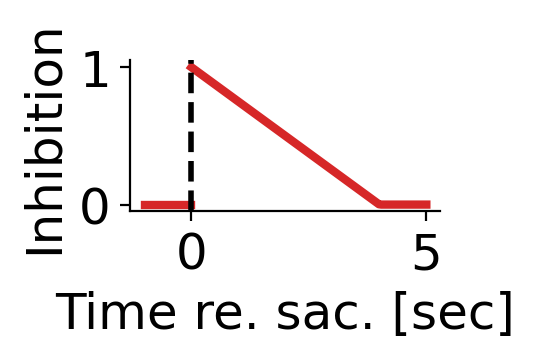

In [13]:
r = 1/120
fig, ax = plt.subplots(figsize=(2,1), dpi=200)
ax.plot([-1,0], [0,0], color='tab:red', lw=3)
x = np.linspace(0,5,100)
y = np.maximum(0, 1 - r * (VidCom.FPS * x)) 
ax.plot(x, y, color='tab:red', lw=3)
ax.axvline(0, ls='--', color='k', lw=2)
fs=18; ax.set_ylabel(r'Inhibition', fontsize=fs)
ax.set_xlabel('Time re. sac. [sec]', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set(yticks=[0, 1], yticklabels=['0', '1'])
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.show()


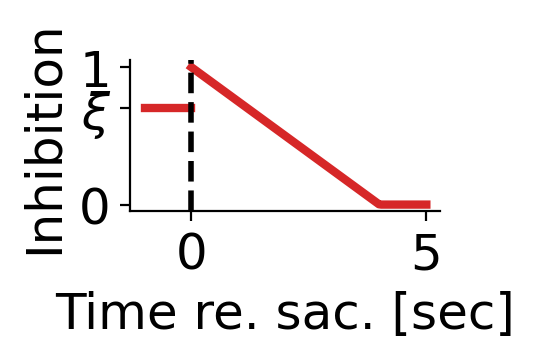

In [14]:
xi = 0.7
fig, ax = plt.subplots(figsize=(2,1), dpi=200)
ax.plot([-1,0], [xi,xi], color='tab:red', lw=3)
x = np.linspace(0,5,100)
y = np.maximum(0, 1 - r * (VidCom.FPS * x)) 
ax.plot(x, y, color='tab:red', lw=3)
ax.axvline(0, ls='--', color='k', lw=2)
fs=18; ax.set_ylabel(r'Inhibition', fontsize=fs)
ax.set_xlabel('Time re. sac. [sec]', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set(yticks=[0, xi, 1], yticklabels=['0', r'$\xi$', '1'])
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.show()


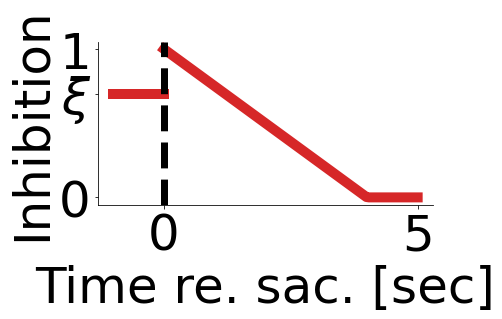

In [15]:
xi = 0.7
fig, ax = plt.subplots(figsize=(6,3))
ax.plot([-1,0], [xi,xi], color='tab:red', lw=10)
x = np.linspace(0,5,100)
y = np.maximum(0, 1 - r * (VidCom.FPS * x)) 
ax.plot(x, y, color='tab:red', lw=10)
ax.axvline(0, ls='--', color='k', lw=7)
fs=50; ax.set_ylabel(r'Inhibition', fontsize=fs)
ax.set_xlabel('Time re. sac. [sec]', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set(yticks=[0, xi, 1], yticklabels=['0', r'$\xi$', '1'])
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.show()


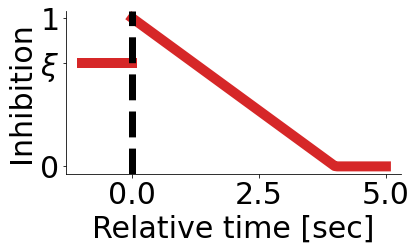

In [16]:
xi = 0.7
fig, ax = plt.subplots(figsize=(6,3))
ax.plot([-1,0], [xi,xi], color='tab:red', lw=10)
x = np.linspace(0,5,100)
y = np.maximum(0, 1 - r * (VidCom.FPS * x)) 
ax.plot(x, y, color='tab:red', lw=10)
ax.axvline(0, ls='--', color='k', lw=7)
fs=30; ax.set_ylabel(r'Inhibition', fontsize=fs)
ax.set_xlabel('Relative time [sec]', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set(yticks=[0, xi, 1], yticklabels=['0', r'$\xi$', '1'])
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.show()


### Object-based IOR
(in the actual model, this is updated, not calculated anew for each frame)

$    I_i(t) = 
    \begin{cases}
        \xi,                            & \text{if } (x_0,y_0) \in O_i\\
        \max\left(0, 1 - r \cdot (t-t_h)\right),    & \text{else.}
    \end{cases}
$

In [17]:
gaze_loc = [400, 350]
assert frame == 230, f"Frame was changed to {frame} in previous cell, should be 230!"

def inhibition(xi, ior_decay, show_prev_target):
    r = 1/ior_decay
    # fig1 showing linear decrease of IOR
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot([-1,0], [xi,xi], color='tab:red', lw=10)
    x = np.linspace(0,5,100)
    y = np.maximum(0, 1 - r * (VidCom.FPS * x)) 
    ax.plot(x, y, color='tab:red', lw=10)
    ax.axvline(0, ls='--', color='k', lw=7)
    fs=30; ax.set_ylabel(r'Inhibition', fontsize=fs)
    ax.set_xlabel('Relative time [sec]', fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.set(yticks=[0, xi, 1], yticklabels=['0', r'$\xi$', '1'])
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    plt.show()
    # fig2 showing object-based inhibition
    I = np.zeros_like(objects, dtype=float)
    for obj_id in np.unique(objects):
        if obj_id == objects[gaze_loc[0], gaze_loc[1]]:
            if obj_id == 0:  # background is not uniformly inhibited
                I[objects==obj_id] = 0
            else:
                I[objects==obj_id] = xi
        else:
            if obj_id == 0:
                last_visited = sp_history[sp_history.object=='Ground'].iloc[-1].frame_end
            else:
                last_visited = sp_history[sp_history.object==f'Object {obj_id}'].iloc[-1].frame_end
            I[objects==obj_id] = max(0, 1-r*(frame - last_visited))
    plt.figure(figsize=(12,6))
    if show_prev_target != "No":
        past_obj = VidCom.get_objectmasks(video)[212]
        plt.contour(past_obj==2, colors='green', linewidths=0.2, linestyles=':') #
        plt.gca().invert_yaxis()
        
    if show_prev_target == "All":
        for s, sac_time in enumerate(sp_history.frame_start[:-1]):
            continue
            plt.scatter(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s], s=500, facecolors='none', 
                    edgecolors='green', linestyle=':', linewidth=2)
        plt.scatter(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s], s=500, facecolors='none', 
                    edgecolors='green', linestyle='--', linewidth=3)

    im = plt.imshow(1-I, vmin=0, vmax=1, cmap='bone')
    # plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.scatter(gaze_loc[1], gaze_loc[0], marker='x', s=1000, c='green', lw=5)
    plt.axis('off'); plt.show()
    
ipyw.interactive(inhibition, 
                 show_prev_target= [ "All", "No", "Yes"],
                 ior_decay=ipyw.FloatSlider(value=100., min=10, max=310, step=30),
                 xi=ipyw.FloatSlider(value=0.7, min=0., max=1.0, step=0.1),
                )

interactive(children=(FloatSlider(value=0.7, description='xi', max=1.0), FloatSlider(value=100.0, description=…

==> Same previous scanpath history, but location-based and object-based IOR lead to very different inhibition patterns!

Now, putting it all together....
## Evidence accumulation for decision making

Evidence for object 0 (in Blues): 0.0896
Evidence for object 2 (in Reds): 0.0332
Evidence for object 3 (in Greens): 0.1853


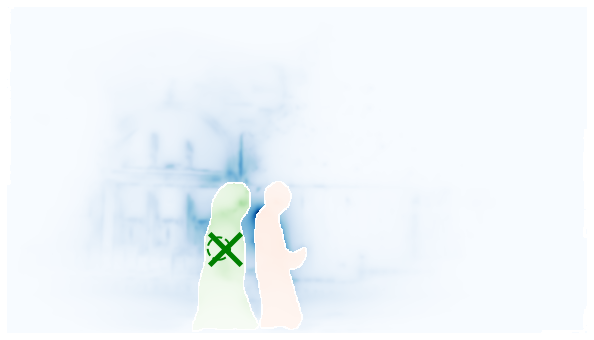

In [18]:
gaze_loc = [400, 350]
frame = 230

ior_decay = 120.
xi = 0.7
att_dva = 10.
ddm_thres = 0.3
ddm_sig = 0.02 

F = VidCom.get_featuremaps(video, 'molin', centerbias='anisotropic_default')[frame]
S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                   att_dva * VidCom.DVA_TO_PX)

obj_id = objects[gaze_loc[0], gaze_loc[1]]
if obj_id > 0:
    S[objects==obj_id] = 1.
# inhibition, usually just scalar for each object, here array for plotting...
r = 1/ior_decay
I = np.zeros_like(objects, dtype=float)
for obj_id in np.unique(objects):
    if obj_id == objects[gaze_loc[0], gaze_loc[1]]:
        if obj_id == 0:
            I[objects==obj_id] = 0  # background is not uniformly inhibited
        else:
            I[objects==obj_id] = xi
    else:
        if obj_id == 0:
            last_visited = sp_history[sp_history.object=='Ground'].iloc[-1].frame_end
        else:
            last_visited = sp_history[sp_history.object==f'Object {obj_id}'].iloc[-1].frame_end
        I[objects==obj_id] = max(0, 1-r*(frame - last_visited))

fig, ax = plt.subplots(figsize=(12,6))
colors = ['Blues', 'Reds', 'Greens']
mu = F * S * (1 - I)
maxval = np.max(mu)
for i, obj_id in enumerate(np.unique(objects)):
    mask = (objects==obj_id); npix = np.sum(mask)
    res = mask * mu 
    print(f'Evidence for object {obj_id} (in {colors[i]}): {round(np.sum(res)*np.log(npix)/npix, 4)}')
    res[res==0] = np.nan
    im = ax.imshow(res, vmin=0, vmax=maxval, cmap=colors[i])
ax.scatter(gaze_loc[1], gaze_loc[0], facecolors='none', edgecolors='green', s=500, lw=2, ls="--")
ax.scatter(gaze_loc[1]+10, gaze_loc[0], marker='x', s=1000, c='green', lw=5)
plt.axis('off'); plt.show()


In [19]:
gaze_loc = [400, 350]
assert frame == 230, f"Frame was changed to {frame} in previous cell, should be 230!"

def loc_evidence_obj(features, center_bias, att_dva, xi, ior_decay): #, theta):
    # select feature / saliency map
    if features == 'Low-level':
        if center_bias == 'yes':
            F = low_level_features_with_cb
        else:
            F = low_level_features
    else:
        if center_bias == 'yes':
            F = high_level_features_with_cb
        else:
            F = high_level_features
    # gaussian visual sensitivity incl. object mask
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       att_dva * VidCom.DVA_TO_PX)
    obj_id = objects[gaze_loc[0], gaze_loc[1]]
    if obj_id > 0:
        S[objects==obj_id] = 1.
    # inhibition, usually just scalar for each object, here array for plotting...
    r = 1/ior_decay
    I = np.zeros_like(objects, dtype=float)
    for obj_id in np.unique(objects):
        if obj_id == objects[gaze_loc[0], gaze_loc[1]]:
            if obj_id == 0:
                I[objects==obj_id] = 0  # background is not uniformly inhibited
            else:
                I[objects==obj_id] = xi
        else:
            if obj_id == 0:
                last_visited = sp_history[sp_history.object=='Ground'].iloc[-1].frame_end
            else:
                last_visited = sp_history[sp_history.object==f'Object {obj_id}'].iloc[-1].frame_end
            I[objects==obj_id] = max(0, 1-r*(frame - last_visited))
    # plot all together
    fig, axs = plt.subplot_mosaic([["F","S","I"], ["D","D","D"]],figsize=(16,12))
    axs['F'].imshow(F, cmap='inferno'); axs['F'].set_title('Scene features $F$', fontsize=20)
    axs['S'].imshow(S, cmap='bone', vmin=0,vmax=1); axs['S'].set_title('Visual sensitivity $S$', fontsize=20)
    axs['I'].imshow(1-I, cmap='bone', vmin=0,vmax=1); axs['I'].set_title('Scanpath history $(1-I)$', fontsize=20)
    colors = ['Blues', 'Greens', 'Reds']
    mu = F * S * (1 - I)
    maxval = np.max(mu)
    for i, obj_id in enumerate(np.unique(objects)):
        mask = (objects==obj_id); npix = np.sum(mask)
        res = mask * mu 
        print(f'Evidence for object {obj_id} (in {colors[i]}): {round(np.sum(res)*np.log(npix)/npix, 4)}')
        res[res==0] = np.nan
        im = axs['D'].imshow(res, vmin=0, vmax=maxval, cmap=colors[i])
    axs['D'].set_title(r'Combined maps: $F\times S \times (1-I)$', fontsize=30)
    [axs[k].set_axis_off() for k in axs.keys()]
    [axs[k].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', linewidth=3) for k in ['S', 'I', 'D']]
    plt.tight_layout(); plt.show()
    
ipyw.interactive(loc_evidence_obj, 
                 features=['Low-level', 'High-level'],
                 center_bias=['yes', 'no'],
                 att_dva=ipyw.FloatSlider(value=10., min=0.5, max=20.0, step=0.5),
                 ior_decay=ipyw.FloatSlider(value=100., min=10, max=310, step=30),
                 xi=ipyw.FloatSlider(value=0.7, min=0., max=1.0, step=0.1),
                 # theta=ipyw.FloatSlider(value=0.3, min=0.1, max=0.5, step=0.05),
                )

interactive(children=(Dropdown(description='features', options=('Low-level', 'High-level'), value='Low-level')…

$$
        \mu_i(t) = \frac{ \left( \sum_{x,y} O_i(x,y,t) \cdot F(x,y,t) \cdot S(x,y,t) \right)  \cdot (1 - I_i(t)) \cdot  \log\sum_{x,y} O_i(x,y,t)}{\sum_{x,y} O_i(x,y,t)}.
$$

*ScanDy* side note: The combined map corresponds to the landing probability within an object.

### Location-based evidence accumulation

$$
\mu_i(t) = \mu(x,y,t) = F(x,y,t) \cdot S(x,y,t) \cdot (J_{X,Y} - I(x,y,t)),
$$

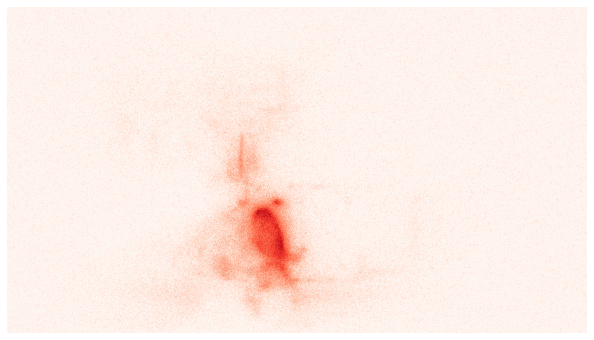

In [20]:
gaze_loc = [400, 350]
frame = 230

ior_decay = 120.
ior_dva = 4.
att_dva = 10.
ddm_thres = 0.3
ddm_sig = 0.02 

F = VidCom.get_featuremaps(video, 'molin', centerbias='anisotropic_default')[frame]
S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                   att_dva * VidCom.DVA_TO_PX)
r = 1/ior_decay
IOR_maps = []
for s, sac_time in enumerate(sp_history.frame_start[:-1]):
    weight = 1-r*(frame - sac_time)
    if weight >0:
        ior_map = weight * uf.gaussian_2d(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s],
                                          VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y,
                                          ior_dva * VidCom.DVA_TO_PX)
        IOR_maps.append(ior_map)
I = np.clip(np.sum(IOR_maps, axis=0), 0, 1)
noise = np.random.normal(0, ddm_sig, F.shape)

plt.figure(figsize=(12,6))
plt.imshow(F * S * (1 - I) + noise, vmin=0, vmax=ddm_thres, cmap='Reds')
plt.axis('off'); plt.show()


In [21]:
gaze_loc = [400, 350]
assert frame == 230, f"Frame was changed to {frame} in previous cell, should be 230!"
# preload features
low_level_features = VidCom.get_featuremaps(video, 'molin', centerbias=None)[frame]
high_level_features = VidCom.get_featuremaps(video, 'TASEDnet', centerbias=None)[frame]
low_level_features_with_cb = VidCom.get_featuremaps(video, 'molin', centerbias='anisotropic_default')[frame]
high_level_features_with_cb = VidCom.get_featuremaps(video, 'TASEDnet', centerbias='anisotropic_default')[frame]


def loc_evidence(features, center_bias, att_dva, ior_dva, ior_decay, ddm_thres, ddm_sig):
    # select feature / saliency map
    if features == 'Low-level':
        if center_bias:
            F = low_level_features_with_cb
        else:
            F = low_level_features
    else:
        if center_bias:
            F = high_level_features_with_cb
        else:
            F = high_level_features
    # gaussian visual sensitivity
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       att_dva * VidCom.DVA_TO_PX)
    # decreasing linearly depending how far back the saccade was
    r = 1/ior_decay
    IOR_maps = []
    for s, sac_time in enumerate(sp_history.frame_start[:-1]):
        weight = 1-r*(frame - sac_time)
        if weight >0:
            ior_map = weight * uf.gaussian_2d(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s],
                                              VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y,
                                              ior_dva * VidCom.DVA_TO_PX)
            IOR_maps.append(ior_map)
    I = np.clip(np.sum(IOR_maps, axis=0), 0, 1)
    # plot all together
    fig, axs = plt.subplot_mosaic([["F","S","I"], ["D","D","D"]],figsize=(16,12))
    axs['F'].imshow(F, cmap='inferno'); axs['F'].set_title('Scene features $F$', fontsize=20)
    axs['S'].imshow(S, cmap='bone', vmin=0,vmax=1); axs['S'].set_title('Visual sensitivity $S$', fontsize=20)
    axs['I'].imshow(1-I, cmap='bone', vmin=0,vmax=1); axs['I'].set_title('Scanpath history $(1-I)$', fontsize=20)
    noise = np.random.normal(0, ddm_sig, F.shape)
    im = axs['D'].imshow(F * S * (1 - I) + noise, vmin=0, vmax=ddm_thres, cmap='Reds')
    axs['D'].set_title(r'Combined maps: $F\times S \times (1-I)$', fontsize=30)
    [axs[k].set_axis_off() for k in axs.keys()]
    [axs[k].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', linewidth=3) for k in ['S', 'I', 'D']]
    cbar = plt.colorbar(im, ax=axs['D'], fraction=0.046, pad=0.04, ticks=[0,ddm_thres/3, ddm_thres*2/3, ddm_thres])
    cbar.ax.set_yticklabels(['0', f'{round(ddm_thres/3,2)}', f'{round(2*ddm_thres/3,2)}', r'$\theta$'], size=20) 
    plt.tight_layout(); plt.show()

In [22]:
ipyw.interactive(loc_evidence, 
                 features=['Low-level', 'High-level'],
                 center_bias=[True, False],
                 att_dva=ipyw.FloatSlider(value=10., min=0.5, max=20.0, step=0.5),
                 ior_decay=ipyw.FloatSlider(value=90., min=30, max=300, step=30),
                 ior_dva=ipyw.FloatSlider(value=5., min=1., max=15.0, step=1.),
                 ddm_thres=ipyw.FloatSlider(value=0.3, min=0.1, max=0.5, step=0.05),
                 ddm_sig=ipyw.FloatSlider(value=0.0, min=0.0, max=0.1, step=0.01),
                )

interactive(children=(Dropdown(description='features', options=('Low-level', 'High-level'), value='Low-level')…

$$
    V_i(t+\Delta t) =  V_i(t) + \mu_i(t) \Delta t + s \epsilon \sqrt{\Delta t}, \\ 
    \text{with } \epsilon \sim \mathcal{N}(0,\,1)
$$

This is just a snapshot, showing the evidence that is accumulated for the decision making during one frame.

This evidence is now accumulated until the decision threshold $\theta$ is crossed, which will trigger a saccade, move the gaze position, and start the accumulation process anew.

## Decision making and gaze update over time

Run the actual model with a given set of parameters to show how decisions are made.

In [23]:
# Initialize the model
pxDDM = PxlDDModel(VidCom)

# Choose sesible parameters
pxDDM.params['ddm_thres'] = 0.4
pxDDM.params['ddm_sig'] = 0.01
pxDDM.params['att_dva'] = 12.5
pxDDM.params['ior_decay'] = 90.
pxDDM.params['ior_dva'] = 9.5

# In this case, we just run it for one video and one random seed (simulated subject)
# This will take a few seconds...
pxDDM.run('field03', seeds=[42]) # [s for s in range(1,13)]
print(pxDDM.result_dict.keys())
print(pxDDM.result_dict['field03'].keys())
print(pxDDM.result_dict['field03']['seed042'].keys())

dict_keys(['field03'])
dict_keys(['seed042'])
dict_keys(['DVs', 'IORs', 'gaze', 'f_sac'])


In [24]:
res = pxDDM.result_dict['field03']['seed042']
low_level_feature_maps = VidCom.get_featuremaps(video, 'molin', centerbias='anisotropic_default')
vidframes = VidCom.get_videoframes(video)
flow_maps = VidCom.get_flowmaps(video)

print('Saccades are made in frames: ', res['f_sac'])

def decision_variable(frame):
    frame = int(frame); theta = pxDDM.params['ddm_thres']
    gaze_loc = res['gaze'][frame]
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       pxDDM.params['att_dva'] * VidCom.DVA_TO_PX)
    I = res['IORs'][frame]
    F = low_level_feature_maps[frame]
    # plot all together
    # fig, axs = plt.subplot_mosaic("FSI;VDO",figsize=(16,12))
    fig, axs = plt.subplots(2,3, figsize=(16,8))
    axs[0,0].imshow(F, cmap='inferno'); axs[0,0].set_title('Scene features $F$', fontsize=20)
    axs[0,1].imshow(S, cmap='bone', vmin=0,vmax=1); axs[0,1].set_title('Visual sensitivity $S$', fontsize=20)
    axs[0,2].imshow(I, cmap='bone', vmin=0,vmax=1); axs[0,2].set_title('Scanpath history $(1-I)$', fontsize=20)
    axs[1,0].imshow(vidframes[frame]); axs[1,0].set_title(f'Original frame {frame}', fontsize=20)
    axs[1,2].imshow(uv.flow_to_color(flow_maps[frame])); axs[1,2].set_title('Optical flow', fontsize=20)
    im = axs[1,1].imshow(res['DVs'][frame], vmin=0, vmax=theta, cmap='Reds')
    axs[1,1].set_title(r'Decision variables $V_i$', fontsize=20)
    [ax.set_axis_off() for ax in axs.flat]
    cbar = plt.colorbar(im, ax=axs[1,1],fraction=0.02, pad=0.04, ticks=[0,theta/3, theta*2/3, theta])
    cbar.ax.set_yticklabels(['0', f'{round(theta/3,1)}', f'{round(2*theta/3,1)}', r'$\theta$'], size=15) 
    [ax.scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', linewidth=3) for ax in axs.flat[1:]]
    if frame > 0:
        axs[1,1].scatter(res['gaze'][frame-1][1], res['gaze'][frame-1][0], s=500, facecolors='none',edgecolors='green', linestyle=':', linewidth=2)
        axs[1,2].scatter(res['gaze'][frame-1][1], res['gaze'][frame-1][0], s=500, facecolors='none',edgecolors='green', linestyle=':', linewidth=2)
    if frame in res['f_sac']:
        axs[1,1].scatter(res['gaze'][frame+1][1], res['gaze'][frame+1][0], s=500, facecolors='none', edgecolors='green', linestyle='-', linewidth=2)
        axs[1,2].scatter(res['gaze'][frame+1][1], res['gaze'][frame+1][0], s=500, facecolors='none', edgecolors='green', linestyle='-', linewidth=2)
    plt.tight_layout(); plt.show()

Saccades are made in frames:  [  0   4   9  25  41  58  77  97 104 111 115 129 143 164 170 183 199 223
 229 236 246 254 269 289]


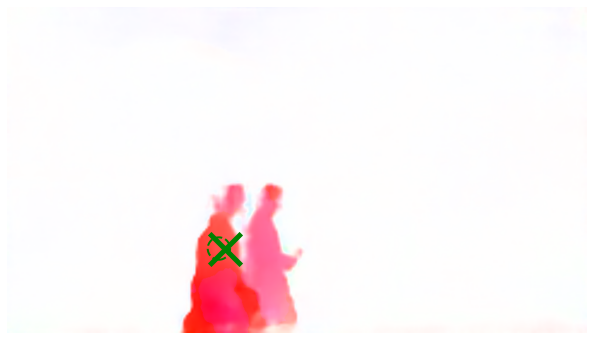

In [25]:
fig, ax = plt.subplots(figsize=(12,6))
ax.imshow(uv.flow_to_color(flow_maps[frame]))
ax.scatter(gaze_loc[1], gaze_loc[0], facecolors='none', edgecolors='green', s=500, lw=2, ls="--")
ax.scatter(gaze_loc[1]+10, gaze_loc[0], marker='x', s=1000, c='green', lw=5)
plt.axis('off'); plt.show()


In [27]:
flow_maps[frame].shape

(540, 960, 2)

In [28]:
# get the highest absolute value of the flow in the x and y direction
max_flow = np.max(np.abs(flow_maps[frame]), axis=(0,1))
max_flow

array([14.94529819,  3.57774305])

In [21]:
ipyw.interactive(decision_variable, 
                 frame=ipyw.FloatSlider(value=230, min=0, max=298, step=1),
                )

interactive(children=(FloatSlider(value=230.0, description='frame', max=298.0, step=1.0), Output()), _dom_clas…

In [22]:
# Initialize the model
objDDM = ObjDDModel(VidCom)

# Choose sesible parameters
objDDM.params['ddm_thres'] = 2.
objDDM.params['ddm_sig'] = 0.2
objDDM.params['att_dva'] = 15.
objDDM.params['ior_decay'] = 180.
objDDM.params['ior_inobj'] = 0.75

# In this case, we just run it for one video and one random seed (simulated subject)
# This will take a few seconds...
objDDM.run('field03', seeds=[2])
print(objDDM.result_dict.keys())
print(objDDM.result_dict['field03'].keys())
print(objDDM.result_dict['field03']['seed002'].keys())

dict_keys(['field03'])
dict_keys(['seed002'])
dict_keys(['DVs', 'IORs', 'gaze', 'f_sac'])


In [23]:
res = objDDM.result_dict['field03']['seed002']
object_maps = VidCom.get_objectmasks(video)

ddm_thres = objDDM.params['ddm_thres']
ddm_sig = objDDM.params['ddm_sig']
att_dva = objDDM.params['att_dva']
ior_decay = objDDM.params['ior_decay']
ior_inobj = objDDM.params['ior_inobj']

print(len(res['f_sac']), 'saccades are made in frames: ', res['f_sac'])

def decision_variable_obj(frame):
    frame = int(frame)
    gaze_loc = res['gaze'][frame]
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       att_dva * VidCom.DVA_TO_PX)
    obj_id = object_maps[frame][gaze_loc[0], gaze_loc[1]]
    if obj_id > 0:
        S[object_maps[frame]==obj_id] = 1.

    I = res['IORs'][frame]
    I = np.zeros_like(objects, dtype=float)
    for obj_id in np.unique(object_maps[frame]):
        I[object_maps[frame]==obj_id] = res['IORs'][frame][obj_id]
    F = low_level_feature_maps[frame]
    # plot all together
    fig, axs = plt.subplots(2,3, figsize=(16,7))#, dpi=200)
    axs[0,0].imshow(F, cmap='inferno'); axs[0,0].set_title('Scene features $F$', fontsize=20)
    axs[0,1].imshow(S, cmap='bone', vmin=0,vmax=1); axs[0,1].set_title('Visual sensitivity $S$', fontsize=20)
    axs[0,1].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', lw=3)
    axs[0,2].imshow(1-I, cmap='bone', vmin=0,vmax=1); axs[0,2].set_title('Scanpath history $(1-I)$', fontsize=20)
    axs[1,0].imshow(vidframes[frame+1]); axs[1,0].set_title(f'Original frame {frame}', fontsize=20)
    axs[1,2].imshow(object_maps[frame], cmap='jet',vmin=0, vmax=3)
    axs[1,2].imshow(vidframes[frame+1], alpha=0.2); axs[1,2].set_title('Object masks', fontsize=20)
    for obj_id in range(4):
        axs[1,1].plot(range(max(0,frame-60),frame), res['DVs'][max(0,frame-60):frame, obj_id], lw=3)
    axs[1,1].set_title(r'Decision variables $V_i$', fontsize=20)
    axs[1,1].set_ylabel(r'$V_i$', fontsize=20)
    axs[1,1].set_xlabel('Time [frames]', fontsize=20)
    axs[1,1].tick_params(labelsize=15)
    axs[1,1].axhline(ddm_thres, c='k', lw=3, ls='--')
    [ax.set_axis_off() for ax in axs.flat]
    axs[1,1].set_axis_on()
    for spine in ['top', 'right']:
        axs[1,1].spines[spine].set_visible(False)
    axs[0,2].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', lw=3)
    axs[1,2].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', lw=3)
    if frame > 0:
        axs[1,2].scatter(res['gaze'][frame-1][1], res['gaze'][frame-1][0], s=500, facecolors='none', 
                    edgecolors='green', linestyle=':', linewidth=3)
    if frame in res['f_sac']:
        axs[1,2].scatter(res['gaze'][frame+1][1], res['gaze'][frame+1][0], s=500, facecolors='none', 
                    edgecolors='green', linestyle='-', linewidth=3)
    plt.tight_layout(); plt.show()

27 saccades are made in frames:  [  4  16  26  34  41  52  67  76  87  99 108 130 139 149 161 170 182 192
 199 209 225 236 248 269 279 286 294]


In [24]:
ipyw.interactive(decision_variable_obj, 
                 frame=ipyw.FloatSlider(value=230, min=0, max=298, step=1),
                )

interactive(children=(FloatSlider(value=230.0, description='frame', max=298.0, step=1.0), Output()), _dom_clas…

---

# How realistic are the simulated scanpaths?

Q: What are the eye movement characteristics that are relevant for studying visual selection of real-world scenes?


In [25]:
VidCom.gt_foveation_df.head()

,duration_ms,x_start,x_end,y_start,y_end,frame_start,frame_end,subject,video,object,sac_amp_dva,sac_angle_h,sac_angle_p,fov_category,ret_times,nfov
0,237.500,481,479,274,276,0,7,DL,dance01,Ground,NaN,NaN,NaN,B,NaN,0
1,437.500,609,559,273,316,9,22,DL,dance01,Object 1,7.680234,-0.447614,NaN,D,NaN,1
2,1470.833,539,314,262,209,25,69,DL,dance01,Object 1,4.251541,-171.069410,-170.621796,I,NaN,2
3,179.167,394,391,345,333,72,77,DL,dance01,Object 2,10.024490,150.212583,-38.718007,D,NaN,3
4,491.667,388,402,322,330,78,92,DL,dance01,Object 2,1.426184,-104.620874,105.166543,I,NaN,4


Human scanpaths are already analyzed and ready to be compared with model predictions:

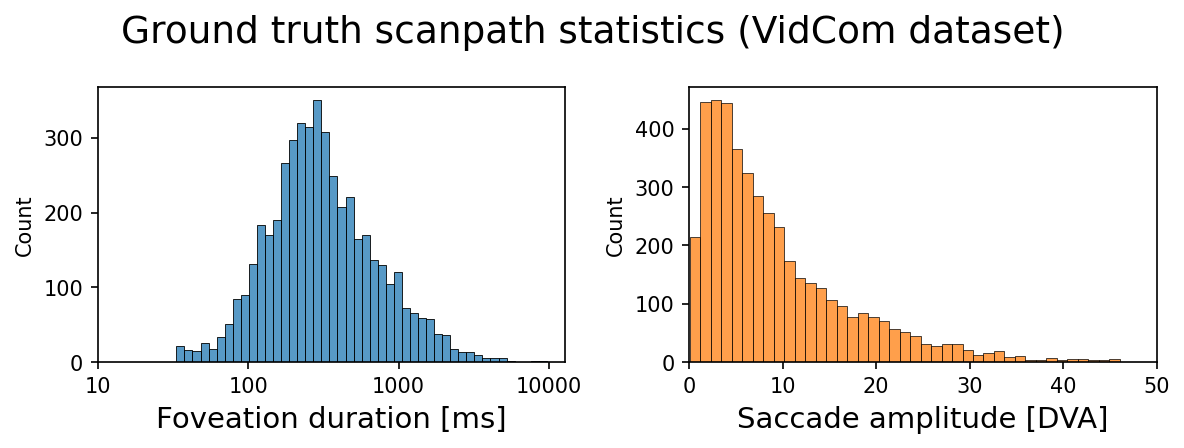

In [26]:
gt_amp_dva = VidCom.gt_foveation_df["sac_amp_dva"].dropna().values
gt_dur_ms = VidCom.gt_foveation_df["duration_ms"].dropna().values

fig, axs = plt.subplots(1,2,dpi=150, figsize=(8,3))
sns.histplot(data=np.log10(gt_dur_ms), kde=False, ax=axs[0])#, bins=20)
axs[0].set_xticks([1,2,3,4])
axs[0].set_xticklabels([10,100,1000,10000])
axs[0].set_xlabel('Foveation duration [ms]', size=14)
sns.histplot(data=gt_amp_dva, kde=False, ax=axs[1], color=sns.color_palette()[1])#, bins=20)
axs[1].set_xlabel('Saccade amplitude [DVA]', size=14)
axs[1].set_xlim([0, 50])
fig.suptitle('Ground truth scanpath statistics (VidCom dataset)', size=18) #   
plt.tight_layout(); plt.show()

In [27]:
names = [
    'Object-based, low-level features',
    'Location-based, low-level features',
]

run_ids = [
    'objDDM_all_molin_32-32-50_2022-07-18-12H-19M-36S_21094388',
    'pxDDM_all_molin_32-32-50_2022-07-08-17H-11M-28S_21087139',
]

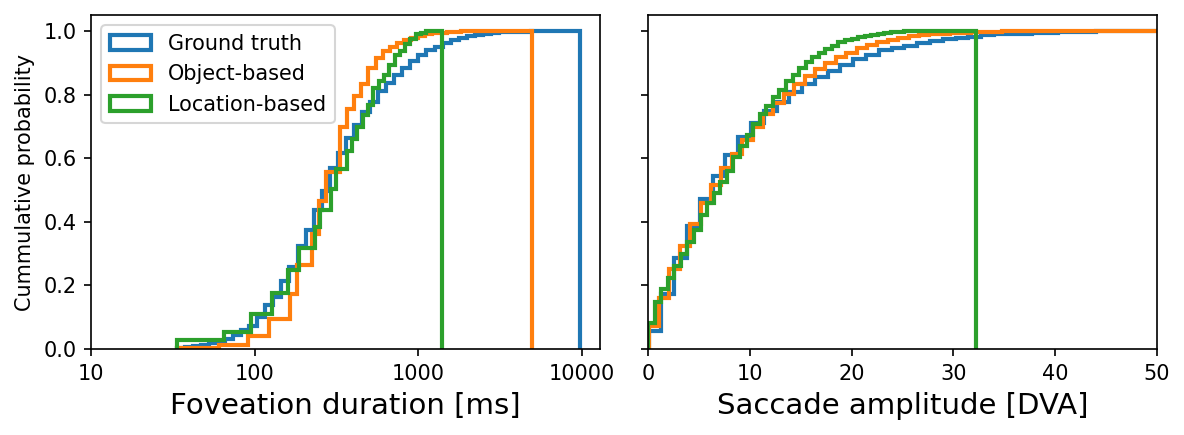

In [28]:
df_res_objMolin_top0 = pd.read_csv(f'./results/{run_ids[0]}/res_df_top0.csv')
obj_dur_ms = df_res_objMolin_top0["duration_ms"].dropna().values
obj_amp_dva = df_res_objMolin_top0["sac_amp_dva"].dropna().values

df_res_pxMolin_top0 = pd.read_csv(f'./results/{run_ids[1]}/res_df_top0.csv')
px_dur_ms = df_res_pxMolin_top0["duration_ms"].dropna().values
px_amp_dva = df_res_pxMolin_top0["sac_amp_dva"].dropna().values

fig, axs = plt.subplots(1,2,dpi=150, figsize=(8,3), sharey=True)
axs[0].hist(np.log10(gt_dur_ms), 50, density=True, histtype='step', cumulative=True, label='Ground truth', lw=2)
axs[0].hist(np.log10(obj_dur_ms), 50, density=True, histtype='step', cumulative=True, label='Object-based', lw=2)
axs[0].hist(np.log10(px_dur_ms), 50, density=True, histtype='step', cumulative=True, label='Location-based', lw=2)
axs[0].set_xticks([1,2,3,4])
axs[0].set_xticklabels([10,100,1000,10000])
axs[0].set_xlabel('Foveation duration [ms]', size=14)
axs[0].set_ylabel('Cummulative probability')
axs[1].hist(gt_amp_dva, 50, density=True, histtype='step', cumulative=True, label='Ground truth', lw=2)
axs[1].hist(obj_amp_dva, 50, density=True, histtype='step', cumulative=True, label='Object-based', lw=2)
axs[1].hist(px_amp_dva, 50, density=True, histtype='step', cumulative=True, label='Location-based', lw=2)
axs[1].set_xlabel('Saccade amplitude [DVA]', size=14)
axs[1].set_xlim([0, 50])
axs[0].legend(loc=2)
plt.tight_layout(); plt.show()

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7fc6090a6620>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7fc60981e6a8>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7fc6090a6a60>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7fc6090a67b8>
MainProcess root INFO     Evolution: Selection operator: <function selBest_multiObj at 0x7fc6090a6840>


===================Object-based, low-level features===================
> Simulation parameters
HDF file storage: ./data/hdf/objDDM_all_molin_32-32-50_2022-07-18-12H-19M-36S_21094388.hdf
Trajectory Name: results-2022-07-18-12H-19M-36S
Duration of evaluating initial population 0:47:33.940112
Duration of evolution 1 day, 14:50:26.466508
Eval function: <function optimize_me at 0x7fc5b9cffd90>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 50
Initial population size: 32
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7fc60981e6a8>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7fc6090a6840>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7fc6090a67b8>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.085
Parameter distribut

/home/nico/anaconda3/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


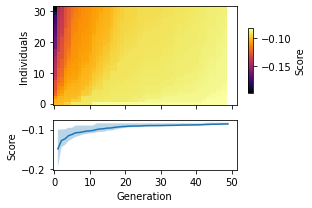

MainProcess root INFO     Saving plot to ./data/figures/results-2022-07-18-12H-19M-36S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.085


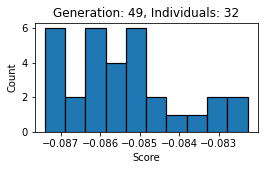

<Figure size 432x288 with 0 Axes>

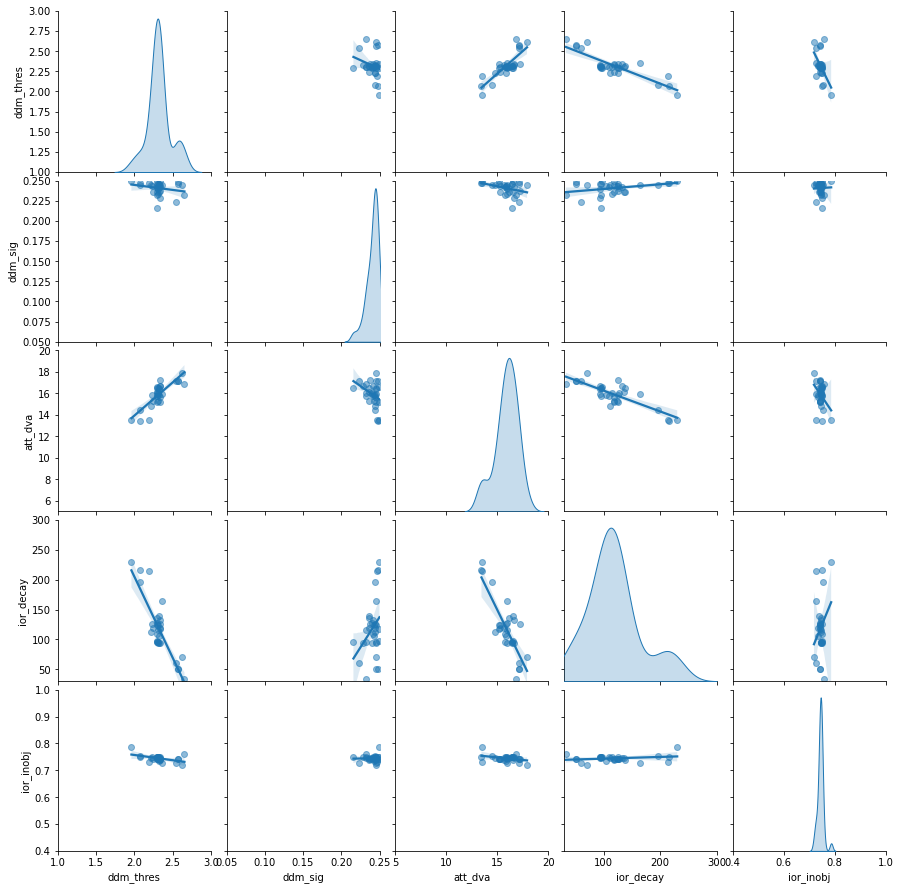

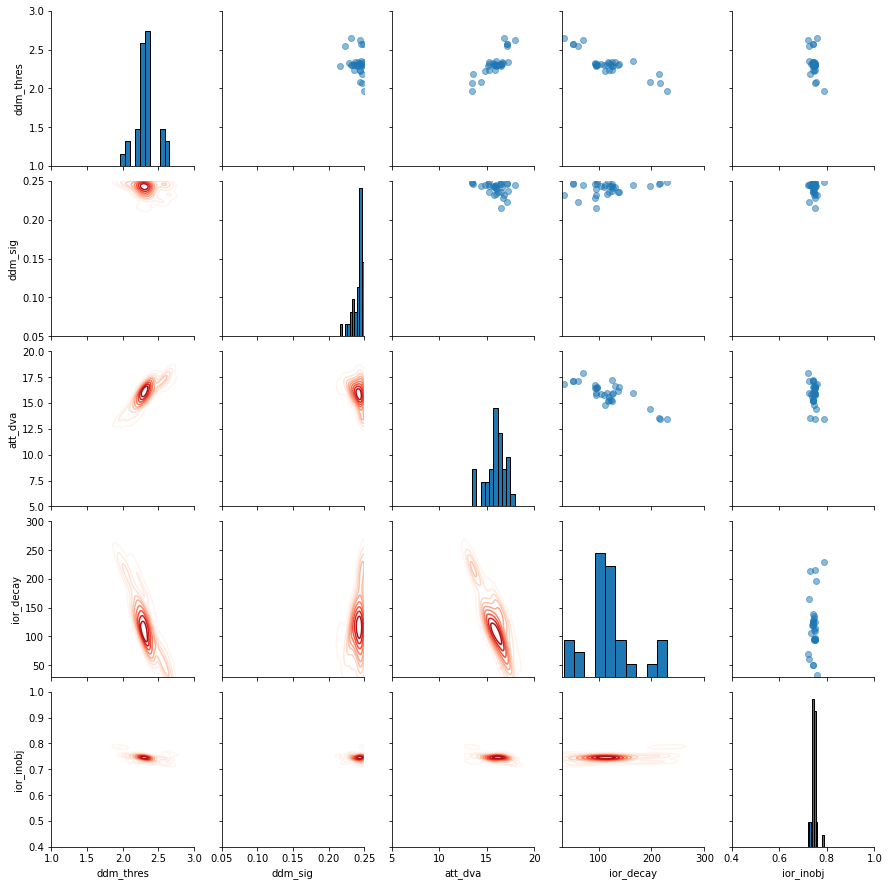

MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".
MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-10-26-13H-56M-20S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-10-26-13H-56M-20S
MainProcess root INFO     Number of cores: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/nico/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/nico/anaconda3/lib/python3.7/site-packa

Object-based, low-level features
 ddm_thres                                                              2.30885
ddm_sig                                                               0.243096
att_dva                                                              15.269073
ior_decay                                                           123.336371
ior_inobj                                                              0.74364
score                                                                -0.082266
id                                                                        1402
gen                                                                         43
fov_cat                      [0.4255434782608696, 0.11521739130434784, 0.28...
fov_cat_number                                         [3338, 730, 2558, 1310]
nss_score_videos_with_std    [[0.7984603439316579, 0.18525742228388953], [-...
f0                                                                     0.12661
f1                

/home/nico/anaconda3/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


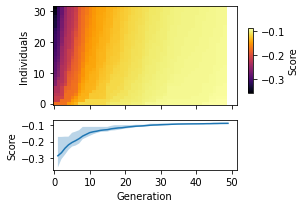

MainProcess root INFO     Saving plot to ./data/figures/results-2022-07-08-17H-11M-28S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.092


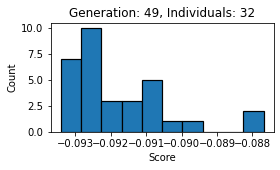

<Figure size 432x288 with 0 Axes>

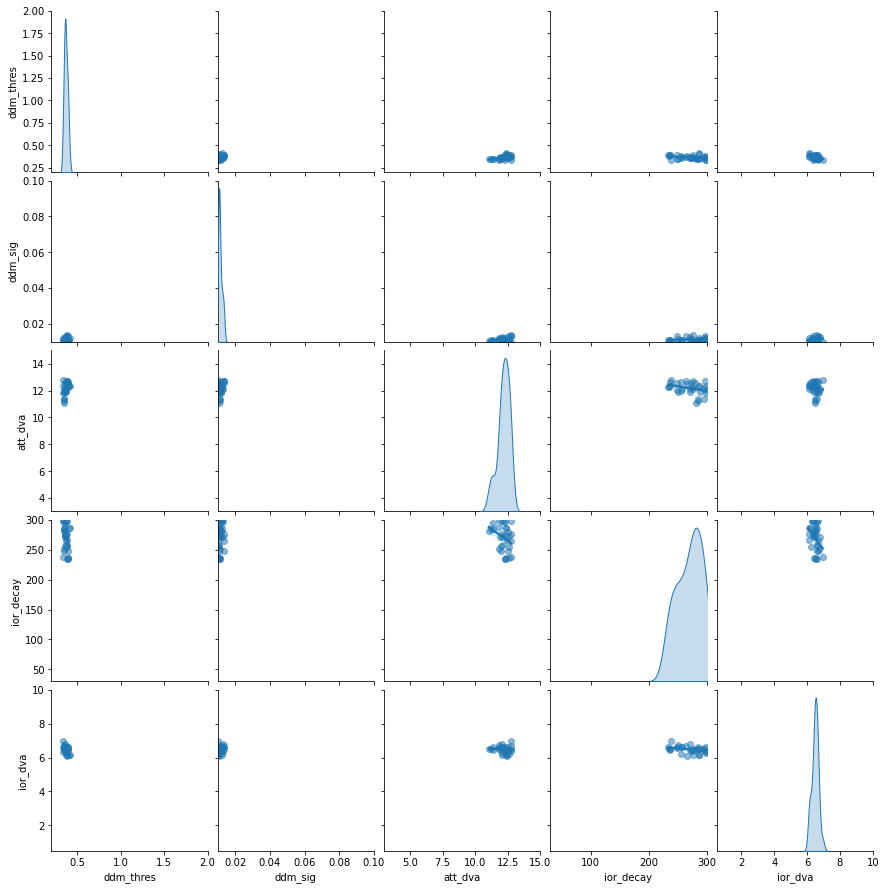

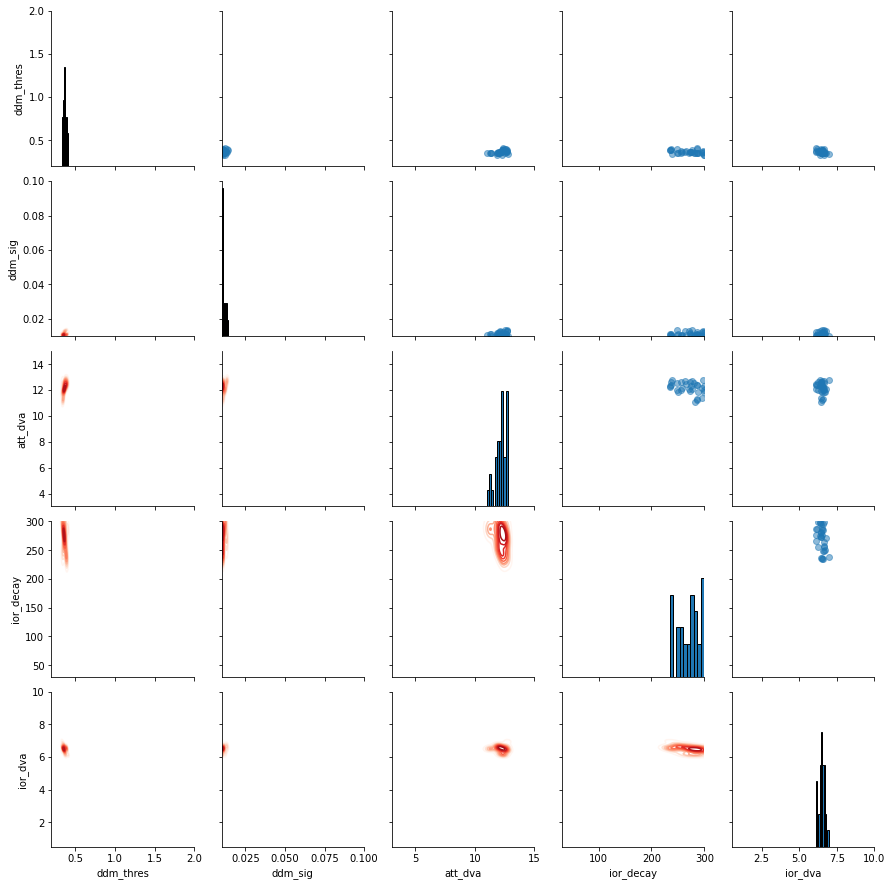

MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Location-based, low-level features
 ddm_thres                                                             0.354945
ddm_sig                                                               0.010152
att_dva                                                              12.548196
ior_decay                                                           280.162501
ior_dva                                                               6.461056
score                                                                -0.087686
id                                                                        1448
gen                                                                         45
fov_cat                      [0.8477173913043479, 0.042644927536231884, 0.0...
fov_cat_number                                           [6225, 470, 481, 320]
nss_score_videos_with_std    [[0.3461082748425728, 0.1869497884663382], [-0...
f0                                                                     0.08315
f1              

In [29]:
for i in [0, 1]:
    runid = run_ids[i]
    print(f'==================={names[i]}===================')
    DILLNAME = f'{runid}.dill'
    evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    evol.info()
    df_evol = evol.dfEvolution(outputs=True)
    print(f'{names[i]}\n', df_evol.sort_values('score', ascending=False).iloc[0])


# Get in contact
## ScanDy mailinglist: http://eepurl.com/h9s6s1 
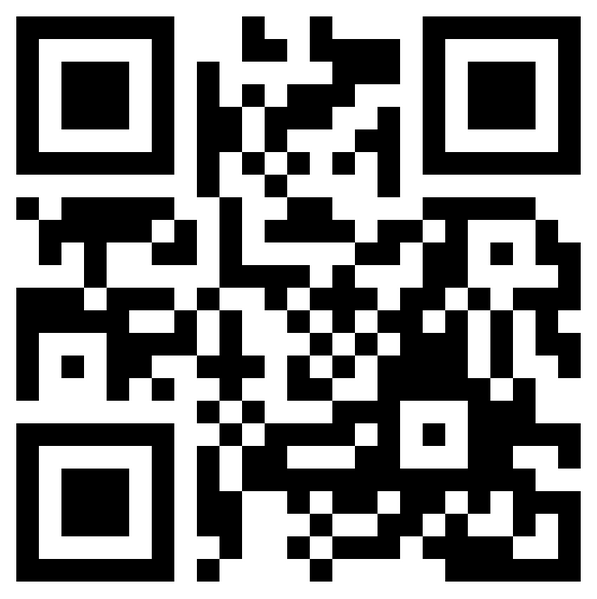

## roth@tu-berlin.de 
